# Minigrid environment

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym
from gym_minigrid import minigrid_env
import numpy as np
import cv2
import random

pygame 2.5.1 (SDL 2.28.2, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload

In [3]:
env = minigrid_env.Env(render_mode="human", size=15, agent_view_size=5,num_tiles=50)
observation, info = env.reset(seed=42)

/home/juan/.virtualenvs/masters_thesis_ws-iu67oo5c/lib/python3.8/site-packages/pygame/sysfont.py:223: UserWarning: 'fc-list' is missing, system fonts cannot be loaded on your platform
  warnings.warn(


In [103]:
%autoreload 2

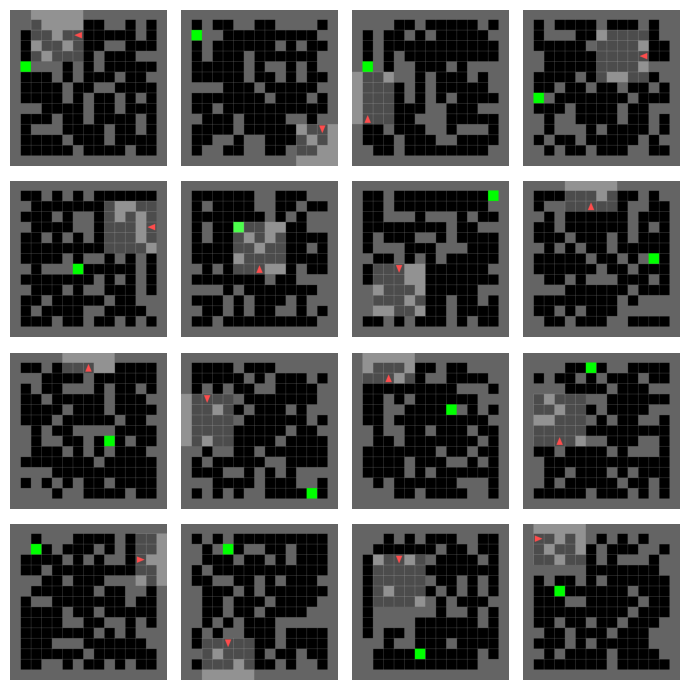

In [111]:
plt.figure(figsize=(7,7))

# Draw 16 environments
for i in range(16):
    plt.subplot(4, 4, i+1)
    _ = env.reset(seed=i)
    plt.imshow(env.get_frame())
    plt.axis('off')

plt.tight_layout()
plt.show()

In [134]:
grids = []
num_grids = 10_000

# Generate a bunch of random grids
for i in range(num_grids):
    env.reset(seed=i)
    grids.append(env.get_full_render(highlight=False, tile_size=1))

    print(f"Generated {i+1}/{num_grids} grids", end="\r")

grids = np.array(grids)

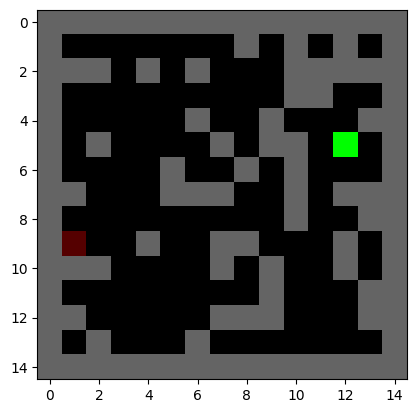

In [146]:
i = random.randint(0, num_grids-1)

plt.imshow(grids[i])

_______

Create dataset

In [182]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class GridsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, grids):
        self.grids = grids

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, index):
        x = TF.to_tensor(self.grids[index])
        return x

In [183]:
X = grids
Y = np.zeros(num_grids)

In [186]:
X.shape

(10000, 15, 15, 3)

In [187]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train)
val_dataset = GridsDataset(X_val)

Train model

In [147]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

In [148]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [283]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=7*7*64):
        return input.view(input.size(0), size, 1, 1)

In [284]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 24, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(24, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(48, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 48, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 32, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(mu.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [306]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

def train(vae, data, epochs=50, bs=32):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
    for epoch in range(epochs):
        for x in data:
            x = x.to(device)
            recon_x, mu, logvar = vae(x)
            loss, bce, kld = loss_fn(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
            print(to_print, end="\r")
        print()

In [307]:
vae = VAE(image_channels=3, z_dim=64, h_dim=7*7*64).to(device) # GPU

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train(vae, train_loader, epochs=100, bs=batch_size)

/home/juan/.virtualenvs/masters_thesis_ws-iu67oo5c/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100] Loss: 148.818 148.699 0.119
Epoch[2/100] Loss: 148.942 148.846 0.097
Epoch[3/100] Loss: 148.776 148.688 0.088
Epoch[4/100] Loss: 147.742 147.617 0.126
Epoch[5/100] Loss: 146.260 146.102 0.158
Epoch[6/100] Loss: 143.472 143.298 0.174
Epoch[7/100] Loss: 143.088 142.907 0.181
Epoch[8/100] Loss: 141.284 141.082 0.202


KeyboardInterrupt: 